# Examining variables with high correlation to increase accuracy and analyze feature importance

## Pre-process data

#### For now, we will look only at continuous values, and then add in our categorical values

In [71]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [72]:
from sklearn.model_selection import train_test_split 
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from math import sqrt

In [73]:
#Import data and analyze
data = r'/Users/OliverPan/Desktop/house/train.csv'

In [74]:
df = pd.read_csv(data)

In [75]:
high_corr = df.corr()["SalePrice"].to_frame().sort_values(by=["SalePrice"])
high_corr = high_corr[high_corr["SalePrice"] > 0.6]
high_corr

,SalePrice
1stFlrSF,0.605852
TotalBsmtSF,0.613581
GarageArea,0.623431
GarageCars,0.640409
GrLivArea,0.708624
OverallQual,0.790982
SalePrice,1.000000


In [76]:
#Take high correlation (above 0.6) into model
corr_df = df[["Id", "SalePrice", "OverallQual","GrLivArea","GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF"]]

### Basic Analysis

#### It seems that the garage and square feet are highly correlated to SalePrice

In [77]:
corr_df.head()

,Id,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF
0,1,208500,7,1710,2,548,856,856
1,2,181500,6,1262,2,460,1262,1262
2,3,223500,7,1786,2,608,920,920
3,4,140000,7,1717,3,642,756,961
4,5,250000,8,2198,3,836,1145,1145


#### OverallQual is the highest correlated variable

In [78]:
corr_df["OverallQual"].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

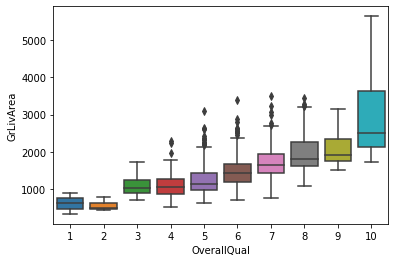

In [79]:
sns.boxplot(y = corr_df["GrLivArea"], x = corr_df["OverallQual"])

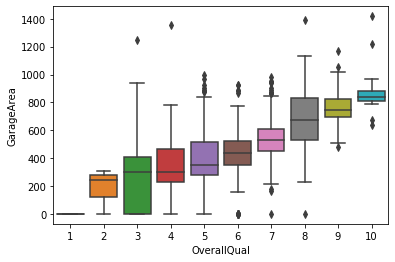

In [80]:
sns.boxplot(y = corr_df["GarageArea"], x = corr_df["OverallQual"])

### Analyse Categorical Values
#### Looking at Categorical values that may have higher correlation to SalePrice

In [81]:
numerical = df[["Id", "SalePrice", "Street", "Alley", "LandSlope", "ExterQual"]]
numerical["Street"] = numerical["Street"].astype('category').cat.codes
numerical["Alley"] = numerical["Alley"].astype('category').cat.codes
numerical["LandSlope"] = numerical["LandSlope"].astype('category').cat.codes
numerical["ExterQual"] = numerical["ExterQual"].astype('category').cat.codes
numerical.head()

/Users/OliverPan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/OliverPan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/OliverPan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,Id,SalePrice,Street,Alley,LandSlope,ExterQual
0,1,208500,1,-1,0,2
1,2,181500,1,-1,0,3
2,3,223500,1,-1,0,2
3,4,140000,1,-1,0,3
4,5,250000,1,-1,0,2


In [82]:
corr_df = pd.merge(corr_df, numerical, on = ["Id", "SalePrice"], how = "left").drop(["Id"], axis = 1)

In [83]:
corr_df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,Street,Alley,LandSlope,ExterQual
0,208500,7,1710,2,548,856,856,1,-1,0,2
1,181500,6,1262,2,460,1262,1262,1,-1,0,3
2,223500,7,1786,2,608,920,920,1,-1,0,2
3,140000,7,1717,3,642,756,961,1,-1,0,3
4,250000,8,2198,3,836,1145,1145,1,-1,0,2


In [84]:
corr_df.corr()["SalePrice"]

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Street         0.041036
Alley         -0.092607
LandSlope      0.051152
ExterQual     -0.636884
Name: SalePrice, dtype: float64

### CatBoost

In [85]:
X = corr_df.drop(["SalePrice"], axis = 1)
y = corr_df[["SalePrice"]]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

In [87]:
cat_boost = CatBoostRegressor(depth=3, learning_rate=0.1, loss_function='RMSE')
cat_boost.fit(X_train, y_train)

0:	learn: 74392.5208827	total: 590us	remaining: 590ms
1:	learn: 70574.2995638	total: 1.2ms	remaining: 599ms
2:	learn: 66703.8337585	total: 1.66ms	remaining: 551ms
3:	learn: 63453.9412976	total: 2.09ms	remaining: 522ms
4:	learn: 60429.8477734	total: 2.54ms	remaining: 506ms
5:	learn: 57457.9273364	total: 3.02ms	remaining: 500ms
6:	learn: 54840.9678993	total: 3.47ms	remaining: 492ms
7:	learn: 52584.6440540	total: 3.92ms	remaining: 486ms
8:	learn: 50585.2743889	total: 4.36ms	remaining: 480ms
9:	learn: 48416.3562452	total: 4.8ms	remaining: 475ms
10:	learn: 46585.1080301	total: 6.08ms	remaining: 547ms
11:	learn: 45060.0573374	total: 6.62ms	remaining: 545ms
12:	learn: 43943.9638413	total: 7.34ms	remaining: 558ms
13:	learn: 42667.8056391	total: 7.81ms	remaining: 550ms
14:	learn: 41788.6097453	total: 8.27ms	remaining: 543ms
15:	learn: 40706.9466032	total: 8.82ms	remaining: 543ms
16:	learn: 39995.7399877	total: 9.38ms	remaining: 542ms
17:	learn: 39000.7850385	total: 9.93ms	remaining: 541ms
18:	l

350:	learn: 20274.0322952	total: 160ms	remaining: 296ms
351:	learn: 20268.3435151	total: 161ms	remaining: 296ms
352:	learn: 20250.6828750	total: 161ms	remaining: 296ms
353:	learn: 20241.3947080	total: 162ms	remaining: 295ms
354:	learn: 20225.2246751	total: 162ms	remaining: 295ms
355:	learn: 20219.2596608	total: 163ms	remaining: 295ms
356:	learn: 20201.5490779	total: 164ms	remaining: 295ms
357:	learn: 20182.2952771	total: 164ms	remaining: 295ms
358:	learn: 20163.7064895	total: 165ms	remaining: 294ms
359:	learn: 20143.8996343	total: 165ms	remaining: 294ms
360:	learn: 20132.6695560	total: 166ms	remaining: 294ms
361:	learn: 20117.3269675	total: 166ms	remaining: 293ms
362:	learn: 20097.1729535	total: 167ms	remaining: 293ms
363:	learn: 20075.0332333	total: 167ms	remaining: 292ms
364:	learn: 20051.9136435	total: 168ms	remaining: 292ms
365:	learn: 20041.5744357	total: 169ms	remaining: 292ms
366:	learn: 20036.2296973	total: 169ms	remaining: 292ms
367:	learn: 20016.5214938	total: 170ms	remaining

658:	learn: 17025.5182470	total: 321ms	remaining: 166ms
659:	learn: 17019.9640524	total: 322ms	remaining: 166ms
660:	learn: 17013.7122856	total: 323ms	remaining: 165ms
661:	learn: 17002.0512577	total: 324ms	remaining: 165ms
662:	learn: 16991.3152378	total: 324ms	remaining: 165ms
663:	learn: 16981.1111166	total: 325ms	remaining: 164ms
664:	learn: 16980.7812398	total: 326ms	remaining: 164ms
665:	learn: 16976.2239097	total: 326ms	remaining: 164ms
666:	learn: 16966.2524243	total: 327ms	remaining: 163ms
667:	learn: 16965.3239019	total: 327ms	remaining: 163ms
668:	learn: 16960.0243663	total: 328ms	remaining: 162ms
669:	learn: 16947.6003772	total: 329ms	remaining: 162ms
670:	learn: 16947.3035169	total: 330ms	remaining: 162ms
671:	learn: 16931.4905799	total: 330ms	remaining: 161ms
672:	learn: 16920.6515081	total: 331ms	remaining: 161ms
673:	learn: 16916.4490235	total: 332ms	remaining: 160ms
674:	learn: 16900.7117144	total: 332ms	remaining: 160ms
675:	learn: 16900.1886325	total: 333ms	remaining

953:	learn: 15275.3139066	total: 482ms	remaining: 23.2ms
954:	learn: 15270.0787436	total: 483ms	remaining: 22.8ms
955:	learn: 15267.0656304	total: 483ms	remaining: 22.3ms
956:	learn: 15261.6433780	total: 484ms	remaining: 21.8ms
957:	learn: 15256.4594344	total: 485ms	remaining: 21.3ms
958:	learn: 15249.5984167	total: 486ms	remaining: 20.8ms
959:	learn: 15241.2373135	total: 486ms	remaining: 20.3ms
960:	learn: 15233.6804981	total: 487ms	remaining: 19.8ms
961:	learn: 15225.3544393	total: 488ms	remaining: 19.3ms
962:	learn: 15214.2283001	total: 488ms	remaining: 18.8ms
963:	learn: 15208.6166973	total: 489ms	remaining: 18.3ms
964:	learn: 15206.5152640	total: 489ms	remaining: 17.7ms
965:	learn: 15200.0243017	total: 490ms	remaining: 17.2ms
966:	learn: 15195.6507690	total: 490ms	remaining: 16.7ms
967:	learn: 15190.8776313	total: 492ms	remaining: 16.2ms
968:	learn: 15188.9841857	total: 492ms	remaining: 15.7ms
969:	learn: 15182.3795257	total: 493ms	remaining: 15.2ms
970:	learn: 15177.0571012	total

In [88]:
y_pred = cat_boost.predict(X_test)

In [89]:
df = pd.DataFrame({'Actual': y_test["SalePrice"].to_list(), 'Predicted': list(y_pred.flatten())})
df.head()

,Actual,Predicted
0,200624,223933.099911
1,133000,147694.431848
2,110000,112163.248425
3,192000,217817.812240
4,88000,102671.462846


In [90]:
## We should also look at RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

31959.155408352803

In [91]:
## Normalised RMSE
sqrt(mean_squared_error(y_test, y_pred)) / (y_test["SalePrice"].max() - y_test["SalePrice"].min())

0.0461504049218091

### Remove low correlation variables which may throw off model

In [93]:
X = corr_df.drop(["SalePrice", "Street", "Alley", "LandSlope"], axis = 1)
y = corr_df[["SalePrice"]]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

In [95]:
cat_boost = CatBoostRegressor(depth=3, learning_rate=0.1, loss_function='RMSE')
cat_boost.fit(X_train, y_train)

0:	learn: 74223.6099303	total: 676us	remaining: 676ms
1:	learn: 69904.9544499	total: 4.19ms	remaining: 2.09s
2:	learn: 66006.3292074	total: 5.84ms	remaining: 1.94s
3:	learn: 62370.5543755	total: 6.66ms	remaining: 1.66s
4:	learn: 59284.8965963	total: 8.44ms	remaining: 1.68s
5:	learn: 56705.9723245	total: 9.03ms	remaining: 1.5s
6:	learn: 54278.2603483	total: 9.7ms	remaining: 1.38s
7:	learn: 51917.7465814	total: 10.4ms	remaining: 1.29s
8:	learn: 49908.7644234	total: 11.1ms	remaining: 1.22s
9:	learn: 48116.1634132	total: 11.6ms	remaining: 1.15s
10:	learn: 46343.1476381	total: 12ms	remaining: 1.08s
11:	learn: 44778.1539507	total: 12.5ms	remaining: 1.03s
12:	learn: 43452.3166475	total: 13ms	remaining: 986ms
13:	learn: 42159.6920545	total: 13.4ms	remaining: 944ms
14:	learn: 41149.3186835	total: 13.9ms	remaining: 910ms
15:	learn: 40194.8625012	total: 14.3ms	remaining: 878ms
16:	learn: 39290.0974628	total: 14.7ms	remaining: 850ms
17:	learn: 38572.2068560	total: 15.2ms	remaining: 832ms
18:	learn

347:	learn: 21249.9187390	total: 162ms	remaining: 303ms
348:	learn: 21227.4174467	total: 162ms	remaining: 303ms
349:	learn: 21205.5963518	total: 163ms	remaining: 303ms
350:	learn: 21188.1741438	total: 164ms	remaining: 304ms
351:	learn: 21178.2339948	total: 165ms	remaining: 304ms
352:	learn: 21158.5833977	total: 166ms	remaining: 304ms
353:	learn: 21145.7610313	total: 166ms	remaining: 304ms
354:	learn: 21132.9975540	total: 167ms	remaining: 303ms
355:	learn: 21119.0173477	total: 168ms	remaining: 303ms
356:	learn: 21110.0362096	total: 168ms	remaining: 303ms
357:	learn: 21086.8723346	total: 169ms	remaining: 302ms
358:	learn: 21081.4262285	total: 169ms	remaining: 302ms
359:	learn: 21063.4944437	total: 170ms	remaining: 302ms
360:	learn: 21038.3154191	total: 170ms	remaining: 302ms
361:	learn: 21031.1582995	total: 171ms	remaining: 301ms
362:	learn: 21012.4788157	total: 172ms	remaining: 302ms
363:	learn: 20998.9528070	total: 173ms	remaining: 302ms
364:	learn: 20983.4286882	total: 173ms	remaining

635:	learn: 17839.3849366	total: 319ms	remaining: 183ms
636:	learn: 17821.3105842	total: 320ms	remaining: 182ms
637:	learn: 17812.2740028	total: 321ms	remaining: 182ms
638:	learn: 17797.0687108	total: 322ms	remaining: 182ms
639:	learn: 17791.6617270	total: 323ms	remaining: 182ms
640:	learn: 17780.3205293	total: 324ms	remaining: 181ms
641:	learn: 17769.9225227	total: 325ms	remaining: 181ms
642:	learn: 17760.2263665	total: 326ms	remaining: 181ms
643:	learn: 17752.4164941	total: 327ms	remaining: 181ms
644:	learn: 17742.6001573	total: 329ms	remaining: 181ms
645:	learn: 17732.8127792	total: 330ms	remaining: 181ms
646:	learn: 17725.7238795	total: 331ms	remaining: 181ms
647:	learn: 17716.6488998	total: 332ms	remaining: 180ms
648:	learn: 17701.0172308	total: 333ms	remaining: 180ms
649:	learn: 17700.6340092	total: 334ms	remaining: 180ms
650:	learn: 17694.0383340	total: 335ms	remaining: 179ms
651:	learn: 17683.9529464	total: 336ms	remaining: 179ms
652:	learn: 17679.3126249	total: 336ms	remaining

954:	learn: 15634.9893131	total: 480ms	remaining: 22.6ms
955:	learn: 15626.9999387	total: 480ms	remaining: 22.1ms
956:	learn: 15619.6319208	total: 481ms	remaining: 21.6ms
957:	learn: 15603.6270922	total: 482ms	remaining: 21.1ms
958:	learn: 15596.6842182	total: 483ms	remaining: 20.6ms
959:	learn: 15593.0791153	total: 483ms	remaining: 20.1ms
960:	learn: 15586.4595255	total: 484ms	remaining: 19.6ms
961:	learn: 15583.7120279	total: 484ms	remaining: 19.1ms
962:	learn: 15583.4899217	total: 485ms	remaining: 18.6ms
963:	learn: 15580.1392812	total: 486ms	remaining: 18.1ms
964:	learn: 15572.1112418	total: 486ms	remaining: 17.6ms
965:	learn: 15571.7927885	total: 487ms	remaining: 17.1ms
966:	learn: 15564.6781006	total: 487ms	remaining: 16.6ms
967:	learn: 15557.7636055	total: 488ms	remaining: 16.1ms
968:	learn: 15549.3894760	total: 488ms	remaining: 15.6ms
969:	learn: 15544.4470916	total: 489ms	remaining: 15.1ms
970:	learn: 15533.7457635	total: 490ms	remaining: 14.6ms
971:	learn: 15529.1162488	total

In [96]:
y_pred = cat_boost.predict(X_test)

In [97]:
df = pd.DataFrame({'Actual': y_test["SalePrice"].to_list(), 'Predicted': list(y_pred.flatten())})
df.head()

,Actual,Predicted
0,200624,232955.526838
1,133000,148291.592213
2,110000,108118.233084
3,192000,220104.652854
4,88000,99616.042852


In [98]:
## Normalised RMSE
sqrt(mean_squared_error(y_test, y_pred)) / (y_test["SalePrice"].max() - y_test["SalePrice"].min())

0.045204594974842555